In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import torchvision
from torchvision import datasets, models, transforms

import composer.functional as cf

import numpy as np
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()   # interactive mode

In [18]:
# Root data path
data_path = 'dataset/'

In [19]:
# Transform
# Architectural elements images are all in 64*64 size, no need to resize as training set
data_transforms = {
    'train':
        transforms.Compose([
            transforms.ToTensor(),
            # from ResNet requirement
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
    'val':
        transforms.Compose([
            transforms.ToTensor(),
            # from ResNet requirement
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
}

In [20]:
# Data load and basic info
# Data load
image_datasets = {x: datasets.ImageFolder(os.path.join(data_path, x),data_transforms[x])
                  for x in ['train', 'val']}

# Into dataloaders
# Adjust batch size and workers given Memory usage
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=10, shuffle=True, num_workers=6)
              for x in ['train', 'val']}

# basic info
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


# Info prints
print("Class Names:", class_names)

print("Train - Val:", dataset_sizes)
print("device available:", device)

Class Names: ['altar', 'apse', 'bell_tower', 'column', 'dome(inner)', 'dome(outer)', 'flying_buttress', 'gargoyle', 'stained_glass', 'vault']
Train - Val: {'train': 9730, 'val': 3658}
device available: cpu


In [21]:
# image show function for visualization
def imshow(tensor, title):
    """
    Imshow for Tensor
    
    Param:
        inp: input tensor
        title: plot title
        
    output:
        matplotlib plot
    """
    # matplotlib imshow() requirement - (M, N, 3): an image with RGB values (0-1 float or 0-255 int).
    # take channel dim (2rd in (B,C,H,W)) into the last
    tensor = tensor.numpy().transpose((1, 2, 0))
    
    # from ResNet requirement
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    
    # de-normalized
    tensor = std * tensor + mean
    
    # ResNet requirement for image load in range [0,1]
    tensor = np.clip(tensor, 0, 1)
    
    plt.imshow(tensor)
    plt.title(title)
    
    # for plot update
    plt.pause(0.001)

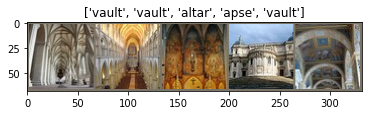

In [22]:
# Get a batch (size 10 set in dataloader) of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch (5 images is the most suitable setting)
grid_data = torchvision.utils.make_grid(inputs[:5])

imshow(grid_data, title=[class_names[x] for x in classes[:5]])

In [24]:
# Train function
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    # time count starts
    since = time.time()

    # best train weights save
    best_model_wts = copy.deepcopy(model.state_dict())
    best_epoch = 0
    best_acc = 0.0

    # Epoch loop
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                # data transfer to desired device
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_epoch = epoch
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    # Time, best epoch and epoch val acc
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best epoch: {best_epoch}')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model

In [25]:
# Finetuning the ConvNet
# Pretrained image Residual ConvNet 50 layers
model_ft = models.resnet50(pretrained=True)

# Check output neuron number
num_ftrs = model_ft.fc.in_features

# fully connected output layer
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

# Loss function setting
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 4 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=4, gamma=0.1)

# Composer speed up
model_ft = cf.apply_blurpool(model_ft)
model_ft = cf.apply_squeeze_excite(model_ft)

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=10)

C:\Users\阿鑫\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
C:\Users\阿鑫\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\阿鑫/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth
100%|█████████████████████████████████████████████████████████████████████████████| 97.8M/97.8M [00:01<00:00, 71.4MB/s]


Epoch 0/9
----------
train Loss: 0.6936 Acc: 0.7784
val Loss: 0.2002 Acc: 0.9352

Epoch 1/9
----------
train Loss: 0.3645 Acc: 0.8801
val Loss: 0.1595 Acc: 0.9492

Epoch 2/9
----------
train Loss: 0.2536 Acc: 0.9173
val Loss: 0.0636 Acc: 0.9811

Epoch 3/9
----------
train Loss: 0.1770 Acc: 0.9410
val Loss: 0.0475 Acc: 0.9858

Epoch 4/9
----------
train Loss: 0.0932 Acc: 0.9707
val Loss: 0.0319 Acc: 0.9918

Epoch 5/9
----------
train Loss: 0.0727 Acc: 0.9786
val Loss: 0.0277 Acc: 0.9923

Epoch 6/9
----------
train Loss: 0.0600 Acc: 0.9831
val Loss: 0.0277 Acc: 0.9923

Epoch 7/9
----------
train Loss: 0.0548 Acc: 0.9826
val Loss: 0.0200 Acc: 0.9948

Epoch 8/9
----------
train Loss: 0.0486 Acc: 0.9872
val Loss: 0.0214 Acc: 0.9951

Epoch 9/9
----------
train Loss: 0.0454 Acc: 0.9863
val Loss: 0.0232 Acc: 0.9943

Training complete in 86m 16s
Best epoch: 8
Best val Acc: 0.995079


In [34]:
def visualize_model(model, num_images):
    was_training = model.training
    model.eval()
    images_no = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_no += 1
                ax = plt.subplot(num_images//2, 2, images_no)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j],class_names[preds[j]])

                if images_no == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)
        


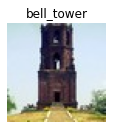

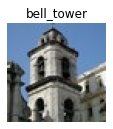

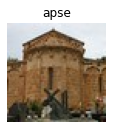

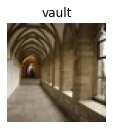

In [35]:
visualize_model(model_ft,4)

In [37]:
# Fixed Feature Extractor
# ResNet
model_conv = torchvision.models.resnet50(pretrained=True)

# keep ResNet unchanged
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, len(class_names))

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 4 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=4, gamma=0.1)

# Composer speed up
model_conv = cf.apply_blurpool(model_conv)
model_conv = cf.apply_squeeze_excite(model_conv)

In [38]:
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=10)

Epoch 0/9
----------
train Loss: 1.0096 Acc: 0.6621
val Loss: 0.6810 Acc: 0.7747

Epoch 1/9
----------
train Loss: 0.8120 Acc: 0.7271
val Loss: 0.5947 Acc: 0.8004

Epoch 2/9
----------
train Loss: 0.7615 Acc: 0.7428
val Loss: 0.5450 Acc: 0.8144

Epoch 3/9
----------
train Loss: 0.7451 Acc: 0.7512
val Loss: 0.5844 Acc: 0.8051

Epoch 4/9
----------
train Loss: 0.6503 Acc: 0.7775
val Loss: 0.4992 Acc: 0.8302

Epoch 5/9
----------
train Loss: 0.6400 Acc: 0.7822
val Loss: 0.5023 Acc: 0.8294

Epoch 6/9
----------
train Loss: 0.6192 Acc: 0.7937
val Loss: 0.5061 Acc: 0.8286

Epoch 7/9
----------
train Loss: 0.6233 Acc: 0.7885
val Loss: 0.4795 Acc: 0.8387

Epoch 8/9
----------
train Loss: 0.6282 Acc: 0.7866
val Loss: 0.4798 Acc: 0.8338

Epoch 9/9
----------
train Loss: 0.6082 Acc: 0.7917
val Loss: 0.4729 Acc: 0.8346

Training complete in 56m 20s
Best epoch: 7
Best val Acc: 0.838710


In [26]:
# Save Model

# FineTuned
# Weights save (needs reinstruct model)
torch.save(model_ft.state_dict(), 'model50.pth')

# Entire Model (needs directory structure)
torch.save(model_ft, 'model50.pt')


In [39]:
# Fixed feature
# Weights save (needs reinstruct model)
torch.save(model_conv.state_dict(), 'modelff.pth')

# Entire Model (needs directory structure)
torch.save(model_conv, 'modelff.pt')